# AUTOGRAD: AUTOMATIC DIFFERENTIATION

Autograd package is central to all neural networks in PyTorch. The ``autograd`` package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

Let us see this in more simple terms with some examples.

## Tensor

``torch.Tensor`` is the central class of the package. If you set its attribute ``.requires_grad`` as ``True``, it starts to track all operations on it. After all computations are finished, ``.backward()`` can be called and have all the gradients computed automatically. The gradient for this tensor will be accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with ``torch.no_grad()``:. This can be particularly helpful when evaluating a model because the model may have trainable parameters with ``requires_grad=True``, but for which we don’t need the gradients.

There’s one more class which is very important for autograd implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a ``.grad_fn`` attribute that references a ``Function`` that has created the ``Tensor`` (except for Tensors created by the user - their ``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to ``backward()``, however if it has more elements, you need to specify a ``gradient`` argument that is a tensor of matching shape.

In [1]:
import torch
import matplotlib.pyplot as plt

from utils import plot_function

Create a tensor and set ``requires_grad=True'' to track computation with it

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Now, do a tensor operation. Since y is created using an operation, so it will have a grad_fn attribute.

In [3]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
print(y.grad_fn)

Do more operation on y

In [5]:
z = y * y * 3
out = z.mean()

print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


``.requires_grad_( ... )`` changes an existing Tensor’s ``requires_grad`` flag in-place. The input flag defaults to ``False`` if not given.



In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


## Gradients

Let's backprop now. Because ``out`` contains a single scalar, ``out.backward()`` is equivalent to ``out.backward(torch.tensor(1.))``.

In [7]:
out.backward()

In [8]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


## Vector Jacobians

### To be done

You can also stop autograd from tracking history on Tensors with ``.requires_grad=True`` either by wrapping the code block in ``with torch.no_grad():``

In [9]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


Or by using ``.detach()`` to get a new Tensor with the same content but that does not require gradients:

In [13]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


### Define a simple algebraic function

"Let's say,

### $$ y = f(x) = x^2 $$

Therefore,

### $$ y' = f'(x) = \frac{d}{dx}(x^2) =  2x $$

In [14]:
def f(x): 
    return x**2

Now plot the graph of f(x)

ABC


/Users/onkar.mishra/Desktop/Personal/Code/gitrepos/pytorch-examples/utils.py:11: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


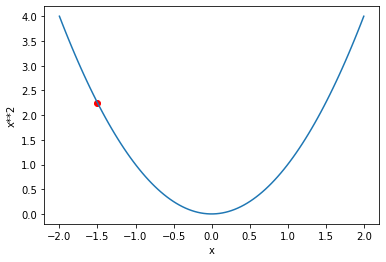

In [15]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now, let’s pick a tensor value xt at which we want gradients. The method ``requires_grad_`` tells PyTorch that we want to calculate gradients with respect to that variable at that value.

In [16]:
xt = torch.tensor(3.).requires_grad_()

In [17]:
yt = f(xt)

In [18]:
yt

tensor(9., grad_fn=<PowBackward0>)

Now, we tell PyTorch to calculate the gradients for us by calling ``.backward()``

In [19]:
yt.backward()

The ``.backward`` here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer. This is called the backward pass of the network, as opposed to the forward pass, which is where the activations are calculated. 

We can now view the gradients by checking the grad attribute of our tensor xt. We know that the derivative of x**2 is 2*x, and at x=3, the gradient would be 2*3=6. This is is what PyTorch calculated for us!

In [20]:
xt.grad

tensor(6.)

Get gradient value for a second time for different value of xt

In [21]:
xt = torch.tensor(2.0, requires_grad=True)

In [22]:
yt.backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In this case, we are trying to do the calculation at different value of x. For this, we redefined the value of x but this throws above RuntimeError. For this, we need to switch on the retain_graph to True in the backward() method to retain the computation graph structure and taking derivatives afterwards¶

In [23]:
xt = torch.tensor(2.0, requires_grad=True)

In [24]:
yt = f(xt)

In [25]:
yt.backward(retain_graph=True)

In [26]:
xt.grad

tensor(4.)

Now, we will repeat the same thing with vector arguement for the function f1(x) defined as below. We will add sum to our function so it it can return a scalar (rank-0 tensor) for a vector (i.e., a rank-1 tensor) input. 

In [27]:
def f1(x): 
    return (x**2).sum()

In [28]:
xt = torch.tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [29]:
yt = f1(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Now, we will tell pytorch to calculate the gradients and calculate the gradient at tensor value xt.

In [30]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Our gradients are 2*xt as expected from calculus rule.

In [62]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

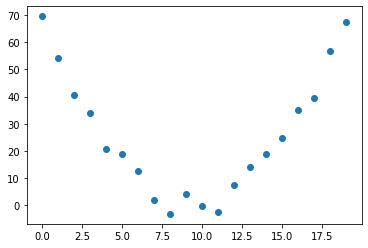

In [63]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [64]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [72]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

In [78]:
params = torch.randn(3).requires_grad_()

In [79]:
params

tensor([-1.1637, -1.9546,  1.7673], requires_grad=True)

In [91]:
orig_params = params.clone()

In [81]:
preds = f(time, params)

In [82]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, preds.detach().numpy(), color='red')
    ax.set_ylim(-300,100)

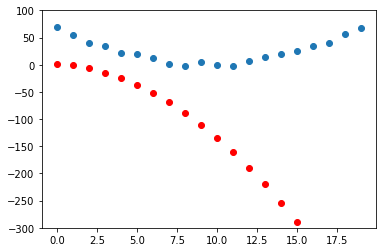

In [83]:
show_preds(preds)

In [104]:
loss = mse(preds, speed)
loss

tensor(239.0610, grad_fn=<SqrtBackward>)

In [108]:
params.parameters()

AttributeError: 'Tensor' object has no attribute 'parameters'

In [105]:
loss.backward()
params.grad

In [106]:
params.grad * 1e-3

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [87]:
params

tensor([-1.1637, -1.9546,  1.7673], requires_grad=True)

In [94]:
params.data

tensor([-1.1620, -1.9545,  1.7673])

In [103]:
params.grad.data

AttributeError: 'NoneType' object has no attribute 'data'

In [102]:
lr = 1e-3
params.data -= lr * params.grad.data
params.grad = None

AttributeError: 'NoneType' object has no attribute 'data'

In [97]:
preds = f(time,params)
mse(preds, speed)

tensor(239.0610, grad_fn=<SqrtBackward>)

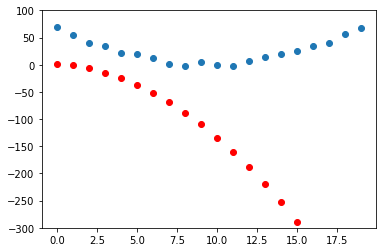

In [98]:
show_preds(preds)

In [99]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [59]:
for i in range(30): apply_step(params)

57.603660583496094
57.381439208984375
57.15968704223633
56.93840789794922
56.71760177612305
56.49728012084961
56.277442932128906
56.058101654052734
55.83925247192383
55.62089920043945
55.40305709838867
55.18572235107422
54.96889877319336
54.752593994140625
54.53681564331055
54.32156753540039
54.10685729980469
53.89268112182617
53.679054260253906
53.46596908569336
53.253440856933594
53.041473388671875
52.83007049560547
52.619239807128906
52.40898132324219
52.199310302734375
51.99021911621094
51.7817268371582
51.57382583618164
51.36652755737305


In [100]:
params = orig_params.detach().requires_grad_()

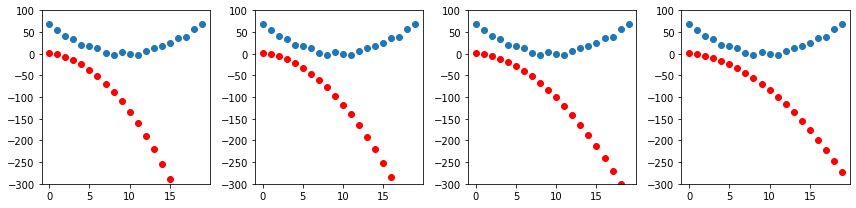

In [101]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()